<a href="https://colab.research.google.com/github/adsamaz/Chattbot/blob/master/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from collections import Counter



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers
    for index, row in data.iterrows():
        word_tokens = word_tokenize(row['Sentence'])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df_ = df_.append({
            "index": row['index'],
            "Class": row['Class'],
            "Sentence": " ".join(filtered_sent[0:])
        }, ignore_index=True)
    return data

In [29]:
# If this is the primary file that is executed (ie not an import of another file)
if __name__ == "__main__":
    # get data, pre-process and split
    data = pd.read_csv("https://raw.githubusercontent.com/adsamaz/Chattbot/master/ANN_project_files/amazon_cells_labelled.txt?token=AL267CS3JPVMWZZ453JJJBC56NPZO", delimiter='\t', header=None)
    data.columns = ['Sentence', 'Class']
    data['index'] = data.index                                          # add new column index
    columns = ['index', 'Class', 'Sentence']
    data = preprocess_pandas(data, columns)                             # pre-process
    training_data, validation_data, training_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
        data['Sentence'].values.astype('U'),
        data['Class'].values.astype('int32'),
        test_size=0.10,
        random_state=0,
        shuffle=True
    )
    print(training_data.shape)

    # vectorize data using TFIDF and transform for PyTorch for scalability
    word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
    training_data = word_vectorizer.fit_transform(training_data)        # transform texts to sparse matrix
    training_data = training_data.todense()                             # convert to dense matrix for Pytorch
    vocab_size = len(word_vectorizer.vocabulary_)
    validation_data = word_vectorizer.transform(validation_data)
    validation_data = validation_data.todense()
    train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
    train_y_tensor = torch.from_numpy(np.array(training_labels)).long()
    validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
    validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()

    print(data)

(900,)
                                              Sentence  Class  index
0    so there is no way for me to plug it in here i...      0      0
1                            good case excellent value      1      1
2                                great for the jawbone      1      2
3    tied to charger for conversations lasting more...      0      3
4                                     the mic is great      1      4
..                                                 ...    ...    ...
995  the screen does get smudged easily because it ...      0    995
996  what a piece of junk i lose more calls on this...      0    996
997                        item does not match picture      0    997
998  the only thing that disappoint me is the infra...      0    998
999  you can not answer calls with the unit never w...      0    999

[1000 rows x 3 columns]


In [0]:
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('/content/drive/My Drive/Chatbot_shared/reviews_Video_Games_5.json.gz')


In [36]:
#Removes everything in except the review and overall score. Then removes
# all reviews with an score of 3 beacuse of them being natrual when we set all
#score under 3 to 0(negative) and score over 3 to 1(positive)
df=data
df=df.get(['Sentence','Class'])
#df=df[df.Class != 3.0] 
#df=df.replace(1.0, 0)
#df=df.replace(2.0, 0)
#df=df.replace(4.0, 1)
#df=df.replace(5.0, 1)
reviews = df.Sentence
labels = df.Class
df


,Sentence,Class
0,so there is no way for me to plug it in here i...,0
1,good case excellent value,1
2,great for the jawbone,1
3,tied to charger for conversations lasting more...,0
4,the mic is great,1
...,...,...
995,the screen does get smudged easily because it ...,0
996,what a piece of junk i lose more calls on this...,0
997,item does not match picture,0
998,the only thing that disappoint me is the infra...,0


In [0]:
#Removes symbols and lowercases all characters
reviews = reviews.str.lower()
reviews = reviews.str.replace(r'[^\w\s]+','')

In [38]:
#Tokenizer
all_text = ' '.join(reviews)          # Makes on string of all texts.
words = all_text.split()

#Count all the words
count_words = Counter(words)          # Creats a counter function

# Sort words after which is most common
total_words = len(words)
sorted_words = count_words.most_common(total_words)
sorted_words

[('the', 513),
 ('i', 316),
 ('and', 310),
 ('it', 281),
 ('is', 243),
 ('a', 218),
 ('this', 206),
 ('to', 196),
 ('phone', 162),
 ('my', 143),
 ('for', 121),
 ('of', 120),
 ('not', 117),
 ('with', 112),
 ('very', 103),
 ('great', 97),
 ('was', 90),
 ('on', 89),
 ('in', 88),
 ('that', 80),
 ('good', 77),
 ('have', 73),
 ('you', 68),
 ('product', 55),
 ('quality', 49),
 ('had', 48),
 ('headset', 47),
 ('works', 47),
 ('but', 46),
 ('battery', 45),
 ('as', 45),
 ('its', 43),
 ('so', 42),
 ('are', 42),
 ('sound', 41),
 ('all', 41),
 ('use', 41),
 ('one', 40),
 ('well', 38),
 ('ear', 35),
 ('has', 34),
 ('would', 34),
 ('work', 34),
 ('from', 33),
 ('your', 32),
 ('dont', 31),
 ('like', 30),
 ('case', 29),
 ('if', 29),
 ('me', 28),
 ('than', 28),
 ('be', 28),
 ('ive', 28),
 ('excellent', 27),
 ('time', 27),
 ('after', 27),
 ('price', 27),
 ('no', 26),
 ('up', 26),
 ('recommend', 26),
 ('does', 26),
 ('really', 26),
 ('at', 24),
 ('im', 24),
 ('or', 23),
 ('best', 23),
 ('service', 23),
 (

In [39]:
# Creats a vocabulary where each number corresponds to a word.

vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

# Changes all word in reviews to interger values accoriding to vocab_to_int
reviews_int = []
for review in reviews:
    r = [vocab_to_int[w] for w in review.split()]
    reviews_int.append(r)
print (reviews_int[0:3])


[[33, 115, 5, 58, 210, 11, 50, 8, 153, 4, 19, 326, 19, 1, 533, 534, 2, 234, 185, 6, 786], [21, 48, 54, 262], [16, 11, 1, 403]]


In [40]:
encoded_labels = np.array(labels)
encoded_labels

array([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,

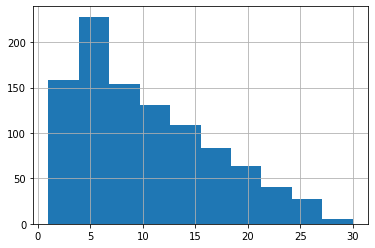

count    1000.000000
mean       10.118000
std         6.598456
min         1.000000
25%         5.000000
50%         9.000000
75%        15.000000
max        30.000000
dtype: float64

In [41]:
#Prints a visualisation of how many word there are in each review
reviews_len = [len(x) for x in reviews_int]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [0]:
# Removes all reviews which have zero words in them.

reviews_int = [ reviews_int[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_labels = [ encoded_labels[i] for i, l in enumerate(reviews_len) if l> 0 ]

In [0]:
# Fucntion which zero padds and shortens all reviews to seq_length

def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review        
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features


In [45]:
features = np.array(pad_features(reviews_int,200))
features[10][:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
# SPlitting data into training, validation and testing
split_frac = 0.6
len_feat=len(features)
encoded_labels = np.array(encoded_labels)

train_x = features[0:int(split_frac*len_feat)]
train_y = encoded_labels[0:int(split_frac*len_feat)]
remaining_x = features[int(split_frac*len_feat):]
remaining_y = encoded_labels[int(split_frac*len_feat):]
valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]
test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]


type(train_y)

numpy.ndarray

In [0]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [48]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) 
# batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) 
# batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[  0,   0,   0,  ...,  81,  15, 111],
        [  0,   0,   0,  ..., 109, 201, 317],
        [  0,   0,   0,  ...,  11, 858,  74],
        ...,
        [  0,   0,   0,  ...,  59,  15,  39],
        [  0,   0,   0,  ..., 375,   7,  24],
        [  0,   0,   0,  ..., 225,  11, 542]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 1])


In [56]:
vocab_size = len(words)
embedding_dim = 30
embeds = nn.Embedding(vocab_size, embedding_dim)
print ('Embedding layer is ', embeds)
print ('Embedding layer weights ', embeds.weight.shape)

embeds_out = embeds(sample_x)
print ('Embedding layer output shape', embeds_out.shape)
print ('Embedding layer output ', embeds_out)

Embedding layer is  Embedding(10118, 30)
Embedding layer weights  torch.Size([10118, 30])
Embedding layer output shape torch.Size([50, 200, 30])
Embedding layer output  tensor([[[ 2.5555e-01,  2.0309e+00, -1.2330e+00,  ...,  2.4847e-01,
          -9.9718e-01,  9.9722e-01],
         [ 2.5555e-01,  2.0309e+00, -1.2330e+00,  ...,  2.4847e-01,
          -9.9718e-01,  9.9722e-01],
         [ 2.5555e-01,  2.0309e+00, -1.2330e+00,  ...,  2.4847e-01,
          -9.9718e-01,  9.9722e-01],
         ...,
         [-1.0275e+00, -2.0627e-01,  1.1695e+00,  ..., -9.1235e-01,
          -5.4317e-01, -2.1056e+00],
         [-3.3015e-01,  1.0118e+00, -1.3435e+00,  ..., -4.8249e-01,
           1.0138e-01,  6.8744e-01],
         [-3.3150e+00,  6.8687e-01, -8.0308e-01,  ..., -1.9401e+00,
          -2.1702e-01,  6.5867e-01]],

        [[ 2.5555e-01,  2.0309e+00, -1.2330e+00,  ...,  2.4847e-01,
          -9.9718e-01,  9.9722e-01],
         [ 2.5555e-01,  2.0309e+00, -1.2330e+00,  ...,  2.4847e-01,
          -9

In [57]:
# initializing the hidden state to 0
hidden=None
lstm = nn.LSTM(input_size=embedding_dim, hidden_size=512, num_layers=1, batch_first=True)
lstm_out, h = lstm(embeds_out, hidden)
print ('LSTM layer output shape', lstm_out.shape)
print ('LSTM layer output ', lstm_out)

LSTM layer output shape torch.Size([50, 200, 512])
LSTM layer output  tensor([[[ 0.0045,  0.0380,  0.0113,  ...,  0.0020,  0.0396, -0.0003],
         [ 0.0049,  0.0543,  0.0187,  ...,  0.0013,  0.0602, -0.0046],
         [ 0.0027,  0.0605,  0.0235,  ..., -0.0002,  0.0723, -0.0096],
         ...,
         [-0.0780, -0.0215,  0.0015,  ..., -0.0352,  0.0486, -0.0115],
         [ 0.0259,  0.0049,  0.0529,  ...,  0.0323,  0.1022, -0.0257],
         [ 0.0105,  0.0264,  0.0202,  ...,  0.0290,  0.0894, -0.0314]],

        [[ 0.0045,  0.0380,  0.0113,  ...,  0.0020,  0.0396, -0.0003],
         [ 0.0049,  0.0543,  0.0187,  ...,  0.0013,  0.0602, -0.0046],
         [ 0.0027,  0.0605,  0.0235,  ..., -0.0002,  0.0723, -0.0096],
         ...,
         [ 0.0420,  0.0918,  0.0079,  ..., -0.0069,  0.0548, -0.0413],
         [ 0.0085,  0.0328,  0.0725,  ..., -0.0199,  0.0609, -0.0224],
         [ 0.0057,  0.0688,  0.0522,  ..., -0.0472,  0.0718,  0.0134]],

        [[ 0.0045,  0.0380,  0.0113,  ...,  0.

In [58]:
fc = nn.Linear(in_features=512, out_features=1)
fc_out = fc(lstm_out.contiguous().view(-1, 512))
print ('FC layer output shape', fc_out.shape)
print ('FC layer output ', fc_out)

FC layer output shape torch.Size([10000, 1])
FC layer output  tensor([[-0.0333],
        [-0.0391],
        [-0.0449],
        ...,
        [-0.0703],
        [-0.0721],
        [-0.0571]], grad_fn=<AddmmBackward>)


In [59]:
sigm = nn.Sigmoid()
sigm_out = sigm(fc_out)
print ('Sigmoid layer output shape', sigm_out.shape)
print ('Sigmoid layer output ', sigm_out)

Sigmoid layer output shape torch.Size([10000, 1])
Sigmoid layer output  tensor([[0.4917],
        [0.4902],
        [0.4888],
        ...,
        [0.4824],
        [0.4820],
        [0.4857]], grad_fn=<SigmoidBackward>)


In [60]:
batch_size = sample_x.shape[0]
out = sigm_out.view(batch_size, -1)
print ('Output layer output shape', out.shape)
print ('Output layer output ', out)

Output layer output shape torch.Size([50, 200])
Output layer output  tensor([[0.4917, 0.4902, 0.4888,  ..., 0.4869, 0.4776, 0.4782],
        [0.4917, 0.4902, 0.4888,  ..., 0.4848, 0.4869, 0.4761],
        [0.4917, 0.4902, 0.4888,  ..., 0.4797, 0.4939, 0.4861],
        ...,
        [0.4917, 0.4902, 0.4888,  ..., 0.4753, 0.4714, 0.4807],
        [0.4917, 0.4902, 0.4888,  ..., 0.4896, 0.4900, 0.4901],
        [0.4917, 0.4902, 0.4888,  ..., 0.4824, 0.4820, 0.4857]],
       grad_fn=<ViewBackward>)


In [61]:
print ('Final sentiment prediction, ', out[:,-1])

Final sentiment prediction,  tensor([0.4782, 0.4761, 0.4861, 0.4878, 0.4922, 0.4892, 0.4928, 0.4948, 0.4913,
        0.4917, 0.4994, 0.4896, 0.4911, 0.4930, 0.4895, 0.4931, 0.4854, 0.4876,
        0.5046, 0.4795, 0.4897, 0.4838, 0.4927, 0.4892, 0.4985, 0.4932, 0.5000,
        0.4822, 0.4755, 0.4886, 0.4950, 0.4850, 0.4897, 0.4817, 0.4866, 0.4763,
        0.4793, 0.4877, 0.4925, 0.4910, 0.4941, 0.5016, 0.4903, 0.4796, 0.4856,
        0.4929, 0.4867, 0.4807, 0.4901, 0.4857], grad_fn=<SelectBackward>)


asd
s

s
s
s

s
s
s
s
s

s
s
s

s

s
s
s






















In [16]:
from gensim.models import KeyedVectors

# Load embeddings from the pre-trained file
# The file can be found in Canvas and must be placed in the same directory as the notebook)
fastText_embeddings = KeyedVectors.load_word2vec_format('/content/drive/My Drive/Chatbot_shared/wiki.simple.vec')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [17]:
word='sweden'
#print(words[0])
test1=fastText_embeddings['sweden']
test2=fastText_embeddings['norway']

print(len(test1))
from scipy import spatial

result = 1 - spatial.distance.cosine(test1, test2)

print(result)

fastText_embeddings.most_similar(positive=['sweden'])

print(fastText_embeddings.wv.vectors.shape)

weights = torch.FloatTensor(fastText_embeddings.vectors)

print(weights)

300
0.597154974937439
(111051, 300)
tensor([[ 0.2892, -0.4608,  0.3514,  ...,  0.1331, -0.2347,  0.0053],
        [ 0.0569, -0.0520,  0.2733,  ..., -0.0695, -0.1606, -0.0989],
        [ 0.2013,  0.0104,  0.1623,  ..., -0.0931, -0.1408, -0.1326],
        ...,
        [ 0.2377, -0.0403, -0.0326,  ..., -0.0606,  0.0348, -0.2974],
        [ 0.5376, -0.2263,  0.0231,  ...,  0.0800, -0.3782, -0.2765],
        [ 0.1598,  0.0028, -0.2026,  ..., -0.0032, -0.1265, -0.1526]])


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


In [49]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cpu


In [0]:


class SentimentNet(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [0]:
vocab_size = len(vocab_to_int) + 1
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

model = SentimentNet(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)

lr=0.005
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [66]:
from tqdm import tqdm
epochs = 1
counter = 0
print_every = 6
clip = 5
valid_loss_min = np.Inf

model.train()
for i in (range(epochs)):
    h = model.init_hidden(batch_size)
    

    for inputs, labels in (train_loader):
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        

        if counter%print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inp, lab in valid_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

KeyboardInterrupt: ignored

In [65]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze())  # Rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Test loss: 0.592
Test accuracy: 71.000%
